In [255]:
import os 
import json
import sys
import geopandas as gpd
import sqlite3
from hyp3_sdk import HyP3

import isce

In [256]:
import functions
from functions import insar_jobs

from functions import send_jobs
from functions import process_tifs
from functions import get_insars
from functions import plot_mean
from functions import all_sites
#from functions import run_mintpy
from functions import mapGNSS

In [257]:
import importlib
importlib.reload(functions)
import functions
from functions import insar_jobs

from functions import send_jobs
from functions import process_tifs
from functions import get_insars
from functions import plot_mean
from functions import all_sites
#from functions import run_mintpy
from functions import mapGNSS

In [258]:
#Connectiong to the postgres database
conn = sqlite3.connect("enrichment.db")
#conn = psycopg2.connect(host='localhost',database = 'postgres', user='postgres',password = 'postgrespw',port=32768)
tableName = "Bonfouca"

In [259]:
#creating the table for the project
cursor = conn.cursor()
cursor.execute(f"CREATE TABLE IF NOT EXISTS {tableName} (primary_scene text, secondary_scene text, site text, insar_name text, primary_date date, secondary_date date, vertdisp_path text, coherence_path text)")
conn.commit()
cursor.close()

In [275]:
#create path to the shapefile you want to use
directory = os.getcwd()
inputFiles = os.path.join(directory,"geodata")
shpPath = os.path.join(inputFiles,'bontest.shp')
output = os.path.join(directory, tableName+'_rawData')
if not os.path.exists(output):
    os.makedirs(output)
mintout = os.path.join(directory, tableName+'mintpy')
if not os.path.exists(mintout):
    os.makedirs(mintout)

In [261]:
jsonFile = open('geodata/Login.json')
login = json.load(jsonFile)

userName = login['UserName']
if userName == "":
    print("Please input Username")
    sys.exit()
password = login['Password']
if password =="":
    print("Please input Password")
    sys.exit()

jsonFile.close()

In [ ]:
#create a list of all insar jobs to be sent to asf 
# bon -> EPSG:26915
# OB_Merge -> EPSG:4326
projectJobs = insar_jobs(shpPath,conn,tableName)

with open("jobs.txt", "w") as output:
    output.write(str(projectJobs))

In [ ]:
#Send project jobs to ASF 
send_jobs(userName,password,projectJobs,output)

In [ ]:
#Uncomment the below code to download your job if it didn't download:

hyp3 = HyP3(username = userName, password = password)
jobName = hyp3.find_jobs(name =tableName)
jobName.download_files(location = output)

In [ ]:
#Crop and reproject all tif files
process = process_tifs(output,tableName,shpPath,conn)

In [ ]:
#select insar list between select time frame
afterEnrichment = 4 #number of weeks after enrichment
preEnrichment = 4 #number of weeks before enrichment
shp = gpd.GeoDataFrame.from_file(shpPath)
print(shp)
name = "LL1A"
for x in range(len(shp)):
    site = shp['Name'][x]
    print(site)
    if site == name:
        date = shp['Date'][x]
        break
print(site)


In [ ]:
site = 'LL1A'
insars = get_insars(tableName,conn,afterEnrichment,preEnrichment,shpPath,site)
stat=plot_mean(insars,shpPath,site)

In [ ]:
all_sites(tableName,conn,shpPath)

In [ ]:
gpsPath = os.path.join(directory, 'CALC.tenv3')
site = 'OBMCA1'
mapGNSS(tableName,conn,shpPath,site,gpsPath,output)

In [283]:
from mintpy.cli import tsview
from mintpy.cli import plot_transection
import pyaps3

!smallbaselineApp.py Bonfoucamintpy/BonfoucaConfig.txt --dir Bonfoucamintpy
'''
%matplotlib widget
ts_file = os.path.expanduser('Bonfoucamintpy/timeseries.h5')
cmd = f'{ts_file} --yx 220 300 --figsize 9 3'
tsview.main(cmd.split())'''


___________________________________________________________

  /##      /## /##             /##     /#######
 | ###    /###|__/            | ##    | ##__  ##
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                |  ######/
   Miami InSAR Time-series software in Python    \______/
          MintPy .1.20, 2023-11-11
___________________________________________________________

--RUN-at-2023-12-05 12:15:46.475518--
Current directory: /Users/melanieayala/Documents/CoastalEnrichment
Run routine processing with smallbaselineApp.py on steps: ['load_data', 'modify_network', 'reference_point', '

"\n%matplotlib widget\nts_file = os.path.expanduser('Bonfoucamintpy/timeseries.h5')\ncmd = f'{ts_file} --yx 220 300 --figsize 9 3'\ntsview.main(cmd.split())"

tsview.py Oystermintpy/timeseries.h5 --yx 220 300 --figsize 9 3
open timeseries file: timeseries.h5
No lookup table (longitude or rangeCoord) found in files.
data   coverage in y/x: (0, 0, 3561, 3061)
subset coverage in y/x: (0, 0, 3561, 3061)
data   coverage in lat/lon: (259880.0, 3441240.0, 544760.0, 3196360.0)
subset coverage in lat/lon: (259880.0, 3441240.0, 544760.0, 3196360.0)
------------------------------------------------------------------------
total number of pixels: 5.5E+08
* multilook 4 by 4 with nearest interpolation for display to save memory
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    exp        : {}
    log        : {}
reading timeseries from file Oystermintpy/timeseries.h5 with step of 4 by 4
reading 2D slices 50/50...
reference to date: 20161004
read mask from file: maskTempCoh.h5
data    range: [-40.056908, 20.325842] cm
display range: [-30.685059, 9.803205] cm
create figure for

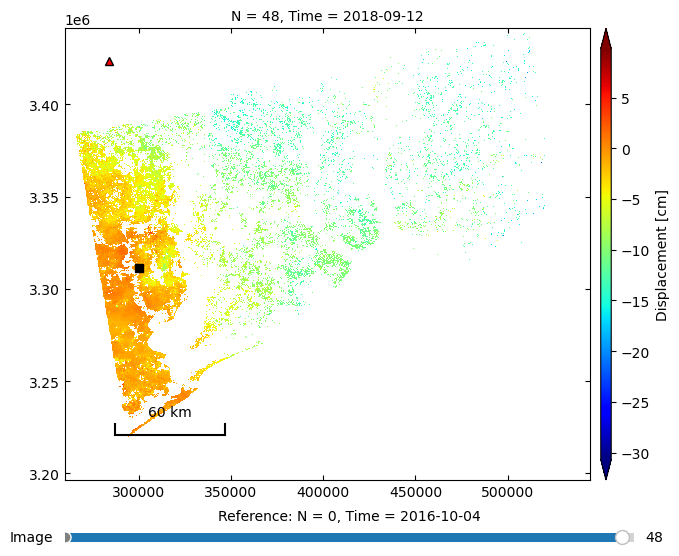

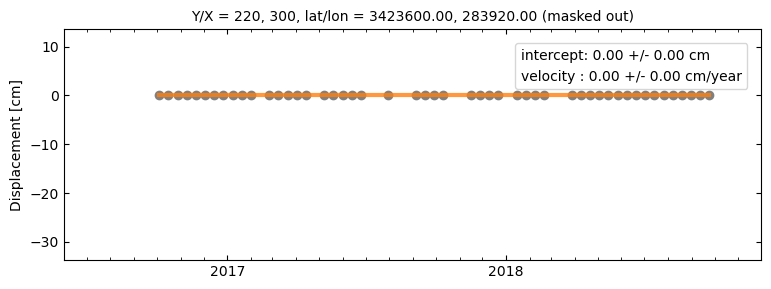

In [197]:
#%matplotlib widget
ts_file = os.path.expanduser('Oystermintpy/timeseries.h5')
cmd = f'{ts_file} --yx 220 300 --figsize 9 3'
tsview.main(cmd.split())

In [ ]:
#!smallbaselineApp.py Oystermintpy/OysterConfig.txt --dostep velocity --dir Oystermintpy
!timeseries2velocity.py ./Oystermintpy/timeseries.h5 -t ./OystermintpysmallbaselineApp.cfg -o ./Oystermintpy/velocity.h5 --update


In [183]:
%matplotlib inline
!view.py Oystermintpy/velocity.h5 velocity -c vik -v -5 5 --alpha 0.75 --noaxis --noverbose

2023-11-29 11:28:11,570 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
view.py Oystermintpy/velocity.h5 velocity -c vik -v -5 5 --alpha 0.75 --noaxis --noverbose
Figure(870x600)


In [ ]:
!closure_phase_bias.py -i inputs/ifgramStack.h5 --bw 3 --nl 2 --memory 2  --num-worker 2 -o ./ -a mask

In [ ]:
!smallbaselineApp.py GalapagosSenDT128.txt --dostep velocity 
#subprocess.run(["smallbaselineApp.py", "--dostep", "velocity", "mintpyConfigFile.txt"])

!timeseries2velocity.py /Users/melanieayala/Documents/CoastalEnrichment/timeseries.h5 -t /Users/melanieayala/Documents/CoastalEnrichment/smallbaselineApp.cfg -o /Users/melanieayala/Documents/CoastalEnrichment/velocity.h5 --update


In [ ]:
%matplotlib inline

from mintpy.cli import view
view.main('OysterMintpy/velocity.h5 --noaxis'.split())

In [ ]:
test_file = os.path.join(directory,'Test_bridging')
test_config = os.path.join(test_file,'mintpyConfigFile_bridging.txt')
print(test_config)

import subprocess
from mintpy.cli import tsview
from mintpy.cli import plot_transection
subprocess.run(["smallbaselineApp.py",test_config])

In [ ]:
'''
DELETE FROM oysterbayou
WHERE rowid NOT IN (
  SELECT MIN(rowid) 
  FROM oysterbayou
  GROUP BY pair, site
);

Select DISTINCT rowid,  * from oysterbayou;
'''